In [5]:
import gdxpds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [6]:
scenarios = list(['nodal', 'with_instrument', 'without_instrument', 'agnostic_instrument']);

scenarios = list(['nodal', 'with_instrument', 'nodal_high_price_elasticity', 'with_instrument_high_price_elasticity']);

nodes = list(['north', 'south'])

In [7]:
def read_data(file, indicator):
    gams_dir='C:\Program Files\GAMS'
    df = gdxpds.to_dataframes(str(file) + '.gdx', gams_dir=gams_dir)
    df = df[indicator]
    df['model'] = file
    if 'Level' in df.columns:
        df['Value'] = df['Level']
    df['Value'] = df['Value'].round(2)
    return(df.set_index(['model']))

def read(indicator):
    if (len(scenarios) == 4):
        df = read_data(scenarios[0], indicator).append(read_data(scenarios[1], indicator)).append(read_data(scenarios[2], indicator)).append(read_data(scenarios[3], indicator))
    elif (len(scenarios) == 3):
        df = read_data(scenarios[0], indicator).append(read_data(scenarios[1], indicator)).append(read_data(scenarios[2], indicator))
    return(df)
    
def plot_distribution(df, axes, location):
    
    width = 0.8
    #baseload
    
    tmp = df.loc[df['tec'] == 'base'][location].fillna(0)
    tmp = tmp.reindex(index = scenarios)
    leg = axes.barh(y_pos, tmp, width, align='center', color = 'darkred')
    left = tmp.fillna(0)

    #peaker
    tmp = df.loc[df['tec'] == 'peak'][location].fillna(0)
    tmp = tmp.reindex(index = scenarios)
    axes.barh(y_pos, tmp, width, left=left, align='center', color = 'black')
    left = left + tmp.fillna(0)

    #wind
    tmp = df.loc[df['tec'] == 'wind'][location].fillna(0)
    tmp = tmp.reindex(index = scenarios)
    axes.barh(y_pos, tmp, width, left=left, align='center', color = 'lightblue')
    left = left + tmp.fillna(0)

    #solar
    tmp = df.loc[df['tec'] == 'solar'][location].fillna(0)
    tmp = tmp.reindex(index = scenarios)
    axes.barh(y_pos, tmp, width, left=left, align='center', color = 'gold')
    left = left + tmp.fillna(0)
    #leg.legend()
    return(axes)

    

In [8]:
df = read('o_gen')
df = df.reset_index().set_index(['model','t', 'n','tec'])
df = df.swaplevel().unstack()
df.columns = df.columns.droplevel(0)
df.columns.name = ''

df = df.groupby(['model','tec']).sum()
df = df.reset_index().set_index(['model'])
gen = df

In [9]:
gen

,tec,north,south
model,,,
nodal,base,67.64,566.49
nodal,peak,7.76,8.12
nodal,solar,0.00,286.00
nodal,wind,434.57,119.20
nodal_high_price_elasticity,base,57.59,514.61
nodal_high_price_elasticity,solar,0.00,286.00
nodal_high_price_elasticity,wind,451.38,160.62
with_instrument,base,16.56,399.12
with_instrument,peak,132.00,182.41


In [10]:
gen['total'] = gen['north'] + gen['south']

In [11]:
gen['type'] = ['RE' if tec in ['wind', 'solar'] else 'non RE' for tec in gen['tec']]

In [12]:
re_shares = gen[['total', 'type']].groupby(['model', 'type']).sum()

In [13]:
re_shares = re_shares.unstack()

In [14]:
re_shares

total        
type                                       RE  non RE
model                                                
nodal                                  839.77  650.01
nodal_high_price_elasticity            898.00  572.20
with_instrument                        691.74  730.09
with_instrument_high_price_elasticity  665.00  777.63

In [15]:
re_shares['total', 'RE'] / (re_shares['total', 'RE'] + re_shares['total', 'non RE'])

model
nodal                                    0.563687
nodal_high_price_elasticity              0.610801
with_instrument                          0.486514
with_instrument_high_price_elasticity    0.460964
dtype: float64

In [16]:
sums = gen.groupby(['model']).sum()
sums['total'] = sums[nodes[0]] + sums[nodes[1]]
sums = sums /48 * 8760
sums['share north'] = sums[nodes[0]] / sums['total']
sums
# in GWh

,north,south,total,share north
model,,,,
nodal,93069.525,178815.325,271884.850,0.342312
nodal_high_price_elasticity,92887.025,175424.475,268311.500,0.346191
with_instrument,88700.475,170783.500,259483.975,0.341834
with_instrument_high_price_elasticity,89069.125,174210.850,263279.975,0.338306


# Installed capacities

In [17]:
df = read('o_cap')
df = df.reset_index().set_index(['model', 'n','tec'])
df = df.swaplevel().unstack()
df.columns = df.columns.droplevel(0)
df.columns.name = ''
df = df.reset_index().set_index(['model'])
capacities = df

In [18]:
capacities

,tec,north,south
model,,,
nodal,base,4.82,30.46
nodal,peak,1.13,1.60
nodal,solar,NaN,100.00
nodal,wind,87.47,31.11
nodal_high_price_elasticity,base,4.06,26.70
nodal_high_price_elasticity,solar,NaN,100.00
nodal_high_price_elasticity,wind,89.18,41.94
with_instrument,base,0.69,16.63
with_instrument,peak,16.13,21.47


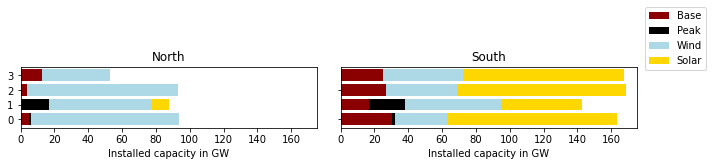

In [20]:
#plt.rcdefaults()
fig = plt.figure(figsize=(10, 2.3))

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

y_pos = np.arange(len(scenarios))
#leg = pd.Dataframe()

plot_distribution(capacities, ax1, 'north')
axes = plot_distribution(capacities, ax2, 'south')

ax1.set_xlim(0, 175)
ax2.set_xlim(0, 175)

ax1.set_title('North')
ax2.set_title('South')
                        
ax2.legend(['Base', 'Peak', 'Wind', 'Solar'], bbox_to_anchor=(1.01, 0.87))
#ax1.legend(['Base', 'Peak', 'Wind', 'Solar'])
ax1.set_yticks(y_pos);
#ax1.set_yticklabels(['First-best', 'Second-best', 'Reference scenario'])
ax2.set_yticklabels([]);
ax1.set_xlabel('Installed capacity in GW')
ax2.set_xlabel('Installed capacity in GW')
plt.tight_layout()

fig.savefig('Figures/capacity_distribution.jpeg', dpi=500)

In [ ]:
# plot generation
#plt.rcdefaults()
fig = plt.figure(figsize=(10, 3.3))

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

y_pos = np.arange(len(scenarios))
#leg = pd.Dataframe()

plot_distribution(gen, ax1, nodes[0])
axes = plot_distribution(gen, ax2, nodes[1])

ax1.set_xlim(0, 1100)
ax2.set_xlim(0, 1100)

ax1.set_title('North')
ax2.set_title('South')
                        
ax2.legend(['Base', 'Peak', 'Wind', 'Solar'], bbox_to_anchor=(1.0, 1))
#ax1.legend(['Base', 'Peak', 'Wind', 'Solar'])
ax1.set_yticks(y_pos);
ax1.set_yticklabels(['Nodal market', 'Locational instrument', 'Reference scenario']);
ax2.set_yticklabels([]);
ax1.set_xlabel('Generation in GWh')
ax2.set_xlabel('Generation in GWh')
plt.tight_layout()

fig.savefig('generation_distribution.jpeg', dpi=500)

# Welfare comparison

In [16]:
welfare = pd.DataFrame(index = scenarios, columns = ['Network cost', 'Generation cost', 'Gross consumer surplus'])

In [17]:
for scenario in scenarios:
    welfare.loc[scenario, 'Network cost'] = read_data(scenario, 'network_cost').iloc[0,0]
    welfare.loc[scenario, 'Generation cost'] = read_data(scenario, 'generation_costs').iloc[0,0]
    welfare.loc[scenario, 'Gross consumer surplus'] = read_data(scenario, 'consumer_surplus').iloc[0,0]

In [18]:
welfare['Welfare'] = welfare['Gross consumer surplus'] - welfare['Network cost'] - welfare['Generation cost'];
welfare['Welfare'] = welfare['Welfare']



In [19]:
welfare = welfare / 1000

In [20]:
welfare.style.format('{0:,.0f}')

,Network cost,Generation cost,Gross consumer surplus,Welfare
nodal,644,"34,577","106,668","71,447"
with_instrument,657,"35,452","105,098","68,988"
without_instrument,"6,067","33,367","105,978","66,545"
agnostic_instrument,"3,322","33,728","105,963","68,913"


In [21]:
print('welfare gains through instrument in %')
    
print(round((welfare['Welfare']['with_instrument'] - welfare['Welfare']['without_instrument']) / welfare['Welfare']['without_instrument'] * 100,2))

print('welfare gains through nodal pricing in %')
    
print(round((welfare['Welfare']['nodal'] - welfare['Welfare']['without_instrument']) / welfare['Welfare']['without_instrument'] * 100,2))

print('welfare loss through uniform signal in %')
    
print(round((welfare['Welfare']['with_instrument'] - welfare['Welfare']['agnostic_instrument']) / welfare['Welfare']['with_instrument'] * 100,2))


welfare gains through instrument in %
3.67
welfare gains through nodal pricing in %
7.37
welfare loss through uniform signal in %
0.11


# Instrument level

In [27]:
fixed_costs = read_data('with_instrument', 'c_fix').reset_index(drop = True).set_index(['tec','n']).unstack()
fixed_costs.columns = fixed_costs.columns.droplevel(0)

In [28]:
fixed_costs

n,north,south
tec,,
base,260.0,260.0
peak,88.0,88.0
solar,137.0,137.0
wind,260.0,260.0


In [29]:
instr = read_data('with_instrument', 'i_instrument').reset_index(drop = True).set_index(['tec','n']).unstack()
instr.columns = instr.columns.droplevel(0)
instr = instr.round(1)

In [30]:
instr

n,north,south
tec,,
base,80.3,79.4
peak,-33.0,-33.3
solar,10.5,30.9
wind,54.2,13.8


In [31]:
cap = read_data('with_instrument', 'o_cap').reset_index(drop = True).set_index(['tec','n']).unstack()
cap.columns = cap.columns.droplevel(0)
instr[cap.isna()] = np.nan

In [32]:
shares = round(100 *instr / fixed_costs,1)

In [33]:
shares = shares.rename(columns={'north':'north (share)', 'south': 'south (share)'})
#shares.columns = shares.columns.droplevel(0)

In [34]:
shares

n,north (share),south (share)
tec,,
base,30.9,30.5
peak,-37.5,-37.8
solar,7.7,22.6
wind,20.8,5.3


In [35]:
instrument = pd.concat([instr, shares], axis=1)
instrument = instrument.sort_index(axis = 1)

In [36]:
#fixed_costs.columns = fixed_costs.columns.droplevel(0)
instrument['Fixed cost'] = fixed_costs['north']

In [37]:
format_dict = {'north':'{0:,.0f} €', 'north (share)': '{0:,.0f}%', 'south': '{0:,.0f} €', 'south (share)': '{0:,.0f}%', 'Fixed cost': '{0:,.0f} €'}
instrument.style.format(format_dict)

n,north,north (share),south,south (share),Fixed cost
tec,,,,,
base,80 €,31%,79 €,30%,260 €
peak,-33 €,-38%,-33 €,-38%,88 €
solar,10 €,8%,31 €,23%,137 €
wind,54 €,21%,14 €,5%,260 €


In [38]:
instr

n,north,south
tec,,
base,80.3,79.4
peak,-33.0,-33.3
solar,10.5,30.9
wind,54.2,13.8


# testing

In [50]:
width = 0.8
#baseload
tmp = df.loc[df['tec'] == 'base'][location].fillna(0)
tmp = tmp.reindex(index = scenarios)

tmp.values



array([ 4.62, 10.65,  9.28,  9.37])

In [49]:
y_pos

array([0, 1, 2, 3])

In [51]:
leg = axes.barh(y_pos, tmp.values, width, align='center', color = 'darkred')
left = tmp

In [52]:
leg

<BarContainer object of 4 artists>

Old

In [ ]:
def read_old(indicator, add = 'prefix'):
    if add == 'prefix':
        df = read_data('Zonal', 'o_' + indicator).append(read_data('Capacity instrument', 'o_' + indicator)).append(read_data('Nodal', 'o_' +  indicator))
        return(df)
    
    elif add == 'prefix_linearized':
        df = read_data('Zonal', 'o_' + indicator).append(read_data('Capacity instrument', 'o_' + indicator)).append(read_data('Capacity instrument linearized', 'i_' + indicator)).append(read_data('Nodal', 'o_' +  indicator))
        return(df)
    
    elif add == None:
        df = read_data('Capacity instrument', indicator).append(read_data('Nodal', indicator)).append(read_data('Zonal', indicator))
        df = df[['tec', 't', 'n', 'Value']]
        return(df)

